## Neural Net for combined Copy Number Variation and RNAseq

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

### Import and Process Data

In [2]:
#Import Data
y = pd.read_table('/Users/a.su/Documents/Cancer_RNAseq_CNV/CancerTypes_y.txt', sep = '\t', header = None)
x_cnv = pd.read_table('/Users/a.su/Documents/Cancer_RNAseq_CNV/CNV_processed.txt', sep = '\t', header = 0)
x_rna = pd.read_table('/Users/a.su/Documents/Cancer_RNAseq_CNV/RNAseq_processed.txt', sep = '\t', header = 0)

# Remove GeneID Column
x_cnv = x_cnv.drop('GeneID', axis = 1)
x_rna = x_rna.drop('GeneID', axis = 1)

# Transpose
x_cnv = x_cnv.transpose()
x_rna = x_rna.transpose()
print('x_cnv shape is:', x_cnv.shape)
print('x_rna shape is:', x_rna.shape)
print('y shape is:', y.shape)

x_cnv shape is: (668, 26094)
x_rna shape is: (668, 26094)
y shape is: (668, 1)


In [3]:
#DropNa from columns with at least 50% NaN
x_cnv_dropped = x_cnv.dropna(thresh = 0.5*len(x_cnv.index))

#Columns dropped
print('Dropped {0} Columns'.format(len(x_cnv.columns) - len(x_cnv_dropped.columns)))

#Impute 
impute_median = SimpleImputer(strategy = 'median')
x_cnv_imputed = impute_median.fit_transform(x_cnv_dropped)
x_cnv_imputed = pd.DataFrame(x_cnv_imputed)

#Check for NaN values
np.isnan(x_cnv_imputed).all().any()

Dropped 0 Columns


False

In [4]:
def count_all_zeros (df, _axis_ = 0):
    return len(df.columns) - np.count_nonzero(df.sum(axis = _axis_), axis = _axis_)

#Count number of columns with all zeros
print('RNA: {0}  CNV: {1}'.format(count_all_zeros(x_rna, 0), count_all_zeros(x_cnv_imputed, 0)))

RNA: 111  CNV: 0


In [5]:
#Delete columns with all zeros
x_cnv_nozero = x_cnv_imputed.loc[:, (x_cnv_imputed != 0).any(axis = 0)]
x_rna_nozero = x_rna.loc[:, (x_rna != 0).any(axis = 0)]

#Count number of column deletions
print('RNA:', x_rna.shape[1] - x_rna_nozero.shape[1])
print('CNV:', x_cnv_imputed.shape[1] - x_cnv_nozero.shape[1])

RNA: 111
CNV: 0


In [6]:
#Count number of columns with all zeros
print('RNA: {0}  CNV: {1}'.format(count_all_zeros(x_rna_nozero, 0), count_all_zeros(x_cnv_nozero, 0)))

RNA: 0  CNV: 0


In [7]:
#Scale data
zscore = lambda x: (x-x.mean())/ x.std()

x_rna_processed, x_cnv_processed = x_rna_nozero.transform(zscore), x_cnv_nozero.transform(zscore)

In [8]:
#Visualise
x_rna_processed[np.random.choice(x_rna_processed.columns.values, size = 10, replace = False)].describe()

,16046,1236,17065,4638,19611,14269,20170,8579,1677,21218
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,2.001684e-16,2.054868e-16,-2.152636e-15,5.903461e-16,3.091340e-17,1.944552e-17,-1.907988e-16,3.310309e-16,-1.555642e-16,-7.859648e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.099321e-01,-5.062090e-02,-1.629005e+00,-1.313737e+00,-3.952953e-01,-2.628895e-01,-1.729910e+00,-3.619205e-01,-8.795716e-01,-1.474050e+00
25%,-4.054556e-01,-5.062090e-02,-7.018702e-01,-5.255807e-01,-3.437117e-01,-2.628895e-01,-6.869773e-01,-3.273578e-01,-6.681921e-01,-6.104550e-01
50%,-3.756354e-01,-5.062090e-02,-2.045003e-01,-2.082984e-01,-2.695236e-01,-2.628895e-01,-1.704542e-01,-2.823355e-01,-3.439054e-01,-2.622204e-01
75%,-1.083684e-01,-5.062090e-02,5.389657e-01,2.311593e-01,-5.055184e-02,-2.628895e-01,4.873515e-01,-1.615190e-01,4.385225e-01,3.172531e-01
max,7.876449e+00,2.382069e+01,6.904179e+00,9.357249e+00,1.612834e+01,1.503229e+01,5.304200e+00,1.153786e+01,6.824215e+00,6.525352e+00


In [9]:
x_cnv_processed[np.random.choice(x_cnv_processed.columns.values, size = 10, replace = False)].describe()

,20665,11989,12631,16736,2416,24872,10883,8083,22498,7283
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,1.137646e-16,1.339996e-17,-5.153064e-16,-6.839173e-17,-4.951129e-16,4.188267e-17,1.027538e-16,3.889429e-17,-2.249531e-16,1.222616e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.513355e+00,-3.047426e+00,-2.723188e+00,-2.536881e+00,-2.650585e+00,-2.855066e+00,-2.764668e+00,-3.139909e+00,-2.767190e+00,-3.530641e+00
25%,-5.512655e-01,-6.530461e-01,-6.466873e-01,-6.279536e-01,-6.114195e-01,-6.834878e-01,-5.861491e-01,-5.659159e-01,-5.682198e-01,-5.518471e-01
50%,-5.431102e-02,6.541808e-04,8.836601e-02,-4.166704e-02,-8.013790e-02,6.602438e-02,-1.119096e-01,-5.370347e-03,-1.293190e-01,2.644476e-02
75%,5.953876e-01,5.837063e-01,6.100552e-01,5.185141e-01,5.358399e-01,5.385110e-01,6.708193e-01,5.975693e-01,5.289132e-01,5.686261e-01
max,3.189324e+00,2.910944e+00,3.134454e+00,4.699214e+00,4.088514e+00,3.186691e+00,3.666028e+00,3.027985e+00,5.779696e+00,3.862350e+00


In [10]:
#Check for NaN values
print('RNA: {0}  CNV: {1}'.format(x_rna_processed.isnull().any().any(), x_cnv_processed.isnull().any().any()))

RNA: False  CNV: False


In [11]:
#Combine CNV and RNA data
x_combined = pd.concat([x_cnv_processed.reset_index(drop = True), x_rna_processed.reset_index(drop = True)] , axis = 1)
y_combined = y
x_combined.shape

(668, 52077)

### Neural Net

In [12]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [13]:
#Split data into training and test sets
x_combined_train, x_combined_test, y_combined_train, y_combined_test = train_test_split(
    x_combined, y_combined.values.flatten(), test_size = 0.25, random_state = 0)

In [82]:
"""
Best setting so far are:

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation = 'sigmoid'))

Accuracy ~81.4%
"""

model = Sequential()
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation = 'sigmoid'))

In [83]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.fit(x_combined_train.values, y_combined_train, epochs = 100, batch_size = 256)

Epoch 1/100
501/501 [==============================] - 17s 35ms/step - loss: 0.8413 - acc: 0.7305
Epoch 2/100
501/501 [==============================] - 14s 27ms/step - loss: 0.7103 - acc: 0.8363
Epoch 3/100
501/501 [==============================] - 14s 28ms/step - loss: 0.6316 - acc: 0.8603
Epoch 4/100
501/501 [==============================] - 13s 26ms/step - loss: 0.3226 - acc: 0.9281
Epoch 5/100
501/501 [==============================] - 2375s 5s/step - loss: 0.4707 - acc: 0.9082
Epoch 6/100
501/501 [==============================] - 14s 28ms/step - loss: 0.3128 - acc: 0.9341
Epoch 7/100
501/501 [==============================] - 14s 27ms/step - loss: 0.2165 - acc: 0.9601
Epoch 8/100
501/501 [==============================] - 15s 29ms/step - loss: 0.2741 - acc: 0.9601
Epoch 9/100
501/501 [==============================] - 13s 27ms/step - loss: 0.2389 - acc: 0.9601
Epoch 10/100
501/501 [==============================] - 14s 28ms/step - loss: 0.1346 - acc: 0.9780
Epoch 11/100
501/50

In [80]:
model.evaluate(x_combined_test, y_combined_test)

167/167 [==============================] - 3s 17ms/step


[3.2905049124163783, 0.7844311380814649]

In [53]:
model.metrics_names

['loss', 'acc']

In [26]:
model.history.history['loss']

[2.712361869697799,
 2.842535646137839,
 2.7175946806719202,
 2.669288774450382,
 2.341652239154199,
 2.5074479242046914,
 2.2964247691179227,
 2.2870805886929144,
 2.455936697904697,
 2.39284881574665,
 2.4461055332553125,
 2.321954621112427,
 2.176153286012585,
 2.288134625809873,
 2.0440334793098436,
 1.9020685250173786,
 2.102909130250622,
 1.780704125665982,
 1.6593140813404927,
 1.7542160278308891]

In [29]:
import matplotlib.pyplot as plt

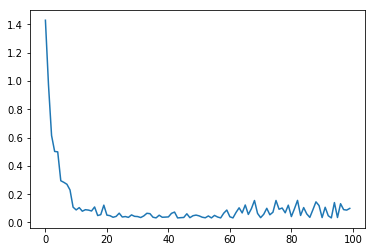

In [81]:
plt.plot(model.history.epoch, model.history.history['loss'])
plt.show()